# The effect of belief interaction on group polarization in networked experiments

Preregistration of analysis code

Todo:
- [x] confidence intervals for game-level measures
- [ ] SEM mediation analysis
- [ ] correlation plot / regression calc btw. game-level imitation difference + pl2 difference and outcome measure difference
- [x] why does startup fixed-effect absorb zero variance? -> very few samples


In [12]:
%pylab inline
%load_ext rpy2.ipython

# for managing data
import pandas as pd
import networkx as nx
import json
from collections import Counter
import itertools
import copy
from datetime import datetime
import scipy.stats as stats

#from lifelines import CoxTimeVaryingFitter # - we'll use R's "survival" package instead
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances as pwdist

import string

Populating the interactive namespace from numpy and matplotlib
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


/usr/local/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy', 'select', 'datetime', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Load data from experiment database

In [13]:
process_games = []
caveman_games = []

In [14]:
export_dir = "../results-anonymized/SIL_test/NaiveBots/"
players = []
with open(export_dir + 'players.jsonl', 'r') as f:
    for line in f:
        players.append(json.loads(line))

games = []
with open(export_dir + 'games.jsonl', 'r') as f:
    for line in f:
        games.append(json.loads(line))
        
treatments = []
with open(export_dir + 'treatments.jsonl', 'r') as f:
    for line in f:
        treatments.append(json.loads(line))

logs = []
with open(export_dir + 'player-logs.jsonl', 'r') as f:
    for line in f:
        entry = json.loads(line)
        entry['data'] = json.loads(entry['jsonData'])
        logs.append(entry)

# match games, players, treatments, and log info
loaded_games = []
for game in games:
    game['players'] = {pl['_id']:pl for pl in players if pl['_id'] in game['playerIds']}
    treatment = [t for t in treatments if t["_id"] == game['treatmentId']][0]
    game['gameSetupId'] = treatment['name']
    game['log'] = [l for l in logs if l['gameId'] == game['_id']]
    
    loaded_games.append(game)
    
for i, game in enumerate(loaded_games):
    print(i, game['createdAt'], game['gameSetupId'])

0 2020-06-01T12:20:36.238Z panel_0_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
1 2020-06-01T12:20:36.481Z panel_0_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots
2 2020-06-01T12:22:02.231Z panel_1_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots
3 2020-06-01T12:22:02.446Z panel_1_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
4 2020-06-01T12:30:14.409Z panel_2_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
5 2020-06-01T12:30:14.592Z panel_2_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots
6 2020-06-01T12:30:15.084Z panel_3_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
7 2020-06-01T12:30:15.326Z panel_3_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots
8 2020-06-01T12:39:19.456Z panel_4_matched_pair_caveman_exp_design6_matched_bots_20200521_115420_allBots
9 2020-06-01T12:39:19.741Z panel_4_matched_pair_exp_design6_matched_bots_20200521_11542

In [15]:
# dodec games
select = []
for i, game in enumerate(loaded_games):
    if 'caveman' not in game['gameSetupId']:
        select.append(i)
        

#select = [0,1,2,3,4,5,6,7]
process_games += [loaded_games[i] for i in select]

for game in process_games:
    print(game['createdAt'], game['gameSetupId'])

2020-06-01T12:20:36.238Z panel_0_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2020-06-01T12:22:02.446Z panel_1_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2020-06-01T12:30:14.409Z panel_2_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2020-06-01T12:30:15.084Z panel_3_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2020-06-01T12:39:19.741Z panel_4_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2020-06-01T12:39:20.246Z panel_6_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2020-06-01T12:47:28.590Z panel_7_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2020-06-01T12:47:29.332Z panel_5_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2020-06-01T12:55:48.322Z panel_8_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2020-06-01T12:55:49.139Z panel_9_matched_pair_exp_design6_matched_bots_20200521_115420_allBots
2020-06-01T13:08:22.896Z panel_11_matched_pair_exp

In [8]:
select = []
for i, game in enumerate(loaded_games):
    if 'caveman' in game['gameSetupId']:
        select.append(i)
        
caveman_games += [loaded_games[i] for i in select]

for game in caveman_games:
    print(game['createdAt'], game['data.gameSetupId'])

2020-06-01T12:20:36.481Z panel_0_matched_pair_caveman_exp_design6_matched_bots_20200521_115420
2020-06-01T12:22:02.231Z panel_1_matched_pair_caveman_exp_design6_matched_bots_20200521_115420
2020-06-01T12:30:14.592Z panel_2_matched_pair_caveman_exp_design6_matched_bots_20200521_115420
2020-06-01T12:30:15.326Z panel_3_matched_pair_caveman_exp_design6_matched_bots_20200521_115420
2020-06-01T12:39:19.456Z panel_4_matched_pair_caveman_exp_design6_matched_bots_20200521_115420
2020-06-01T12:39:20.405Z panel_6_matched_pair_caveman_exp_design6_matched_bots_20200521_115420
2020-06-01T12:47:28.859Z panel_7_matched_pair_caveman_exp_design6_matched_bots_20200521_115420
2020-06-01T12:47:29.515Z panel_5_matched_pair_caveman_exp_design6_matched_bots_20200521_115420
2020-06-01T12:55:48.520Z panel_8_matched_pair_caveman_exp_design6_matched_bots_20200521_115420
2020-06-01T12:55:48.970Z panel_9_matched_pair_caveman_exp_design6_matched_bots_20200521_115420
2020-06-01T13:08:23.183Z panel_11_matched_pair_cav

# Compute game-level measures

In [239]:
# randomization algorithm

m1 = np.random.binomial(1, .3, size=(6,8))

def flip1(m):
    """
    Chooses a single (i0, j0) location in the matrix to 'flip'
    Then randomly selects a different (i, j) location that creates
    a quad [(i0, j0), (i0, j), (i, j0), (i, j) in which flipping every
    element leaves the marginal distributions unaltered.  
    Changes those elements, and returns 1.
    
    If such a quad cannot be completed from the original position, 
    does nothing and returns 0.
    """
    i0 = np.random.randint(m.shape[0])
    j0 = np.random.randint(m.shape[1])
    
    level = m[i0, j0]
    flip = 0 if level == 1 else 1  # the opposite value
    
    for i in np.random.permutation(range(m.shape[0])):  # try in random order
        if (i != i0 and  # don't swap with self
            m[i, j0] != level):  # maybe swap with a cell that holds opposite value
            for j in np.random.permutation(range(m.shape[1])):
                if (j != j0 and  # don't swap with self
                    m[i, j] == level and  # check that other swaps work
                    m[i0, j] != level):
                    # make the swaps
                    m[i0, j0] = flip
                    m[i0, j] = level
                    m[i, j0] = level
                    m[i, j] = flip
                    return 1
                
    return 0
        
def shuffle(m1, n=100):
    m2 = m1.copy()
    f_success = np.mean([flip1(m2) for _ in range(n)])
    
    # f_success is the fraction of flip attempts that succeed, for diagnostics
    #print(f_success)
    
    # check the answer
    assert(all(m1.sum(axis=1) == m2.sum(axis=1)))
    assert(all(m1.sum(axis=0) == m2.sum(axis=0)))
    
    return m2

    
m2 = shuffle(m1)

In [249]:
def compute_single_point_measures(game):
    """ Compute the game-level measures """
    # Form end-of-game survey responses into a dataframe
    collector = {}
    for p, k in game['players'].items():
        try:
            collector[k['data.position']] = [1]
        except:
            print('%s did not complete the post-game survey' %k['data.position'])
    responses = pd.DataFrame(collector).T.sort_index()

    # Define clues used in polarization analysis
    # final clues used in analysis are connections between hub nodes (1,2) and rim nodes (3-13)
    t_spokes = ['tclue_1_3', 'tclue_1_4', 'tclue_1_5', 'tclue_1_6', 'tclue_1_7', 
                'tclue_1_8', 'tclue_1_9', 'tclue_1_10','tclue_1_11', 'tclue_1_12', 'tclue_1_13',
                'tclue_2_3', 'tclue_2_4', 'tclue_2_5', 'tclue_2_6', 'tclue_2_7',
                'tclue_2_8', 'tclue_2_9', 'tclue_2_10', 'tclue_2_11', 'tclue_2_12', 'tclue_2_13']

    c_spokes = ['cclue_1_3', 'cclue_1_4', 'cclue_1_5', 'cclue_1_6', 'cclue_1_7', 
                'cclue_1_8', 'cclue_1_9', 'cclue_1_10','cclue_1_11', 'cclue_1_12', 'cclue_1_13',
                'cclue_2_3', 'cclue_2_4', 'cclue_2_5', 'cclue_2_6', 'cclue_2_7',
                'cclue_2_8', 'cclue_2_9', 'cclue_2_10', 'cclue_2_11', 'cclue_2_12', 'cclue_2_13']

   
    # Form final notebook states into a dataframe
    final_adoptions = pd.DataFrame(data=0, index=responses.index, columns=t_spokes+c_spokes)
    for p, k in game['players'].items():
        for clue_id in k['data.notebooks']['promising_leads']['clueIDs']:
            final_adoptions.loc[k['data.position'], clue_id] = 1


    # Determine the number of datapoints to be used in polarization analysis
    # if there are missing responses, need to compare equal sized datasets
    t_responses = [pos for pos in responses.index if pos.startswith('t')]
    c_responses = [pos for pos in responses.index if pos.startswith('c')] 
    # use whichever condition has fewer responses to set the sample size
    n_used = min(len(t_responses), len(c_responses))


    def process_subset(subset, spokes, prefix='_t'):
        """ compute a result on the selected subset of the data """
        sub_res = {}
        sub_adopt = final_adoptions.loc[subset, spokes]

        # final-state PC1
        pca = PCA(n_components=1)
        pca.fit(sub_adopt)  
        sub_res[prefix+'spoke_pc1_variance'] = pca.explained_variance_ratio_
        
        # final state similarity percentiles
        sub_res[prefix+'spoke_5th_similarity'], sub_res[prefix+'spoke_95th_similarity'] = np.percentile(
            sub_adopt.T.corr().mask(np.tri(n_used, n_used, 0, dtype='bool')).stack(), 
            [5, 95]
        )
        
        e95 = []
        e5 = []
        ePC1 = []
        for _ in range(100):
            shuffle_adopt = pd.DataFrame(index=sub_adopt.index,
                                         columns=sub_adopt.columns,
                                         data=shuffle(sub_adopt.values, n=500))
            
            n_agents = len(shuffle_adopt.index)
            corrs = shuffle_adopt.astype(float).T.corr().mask(np.tri(n_agents, n_agents, 0, dtype='bool')).stack()
            e95.append(np.percentile(corrs, 95))
            e5.append(np.percentile(corrs, 5))

            pca = PCA(n_components=1)
            pca.fit(shuffle_adopt)
            ePC1.append(pca.explained_variance_ratio_[0])
        
        sub_res[prefix+'expected_pc1_variance'] = np.mean(ePC1)
        sub_res[prefix+'expected_95th_similarity'] = np.mean(e95)
        sub_res[prefix+'expected_5th_similarity'] = np.mean(e5)
                
        return sub_res
        
        
    # For each subset of size 'n_used', compute a result. 
    # In most cases there are no missing responses, so just compute on the complete set
    t_collector = []
    for subset in itertools.combinations(t_responses, r=n_used):
        t_collector.append(process_subset(subset, t_spokes, prefix='t_'))

    # The recorded result is the average over all subsets
    if len(t_collector) > 1:
        print('Averaging over %i combinations for treatment case'%len(t_collector))
    t_result = pd.DataFrame(t_collector).mean()

    
    # Perform the same analysis as above for the control condition
    c_collector = []
    for subset in itertools.combinations(c_responses, r=n_used):
        c_collector.append(process_subset(subset, c_spokes, prefix='c_'))

    if len(c_collector) > 1:
        print('Averaging over %i combinations for control case'%len(c_collector))
    c_result = pd.DataFrame(c_collector).mean()
  

    
    result = pd.concat([t_result, c_result])
    result['game_id']=game['createdAt'].split('_')[0].replace('-','_').replace(':','_').replace('.','_')
    return result


In [250]:
compute_single_point_measures(process_games[0])

t_spoke_pc1_variance                           0.30579
t_spoke_5th_similarity                       -0.330623
t_spoke_95th_similarity                       0.614603
t_expected_pc1_variance                       0.197494
t_expected_95th_similarity                    0.442887
t_expected_5th_similarity                    -0.265081
c_spoke_pc1_variance                          0.327843
c_spoke_5th_similarity                       -0.370479
c_spoke_95th_similarity                       0.580771
c_expected_pc1_variance                       0.210937
c_expected_95th_similarity                    0.398097
c_expected_5th_similarity                    -0.247635
game_id                       2020_06_01T12_20_36_238Z
dtype: object

In [251]:
processed = [compute_single_point_measures(game) for game in process_games]
spms = pd.DataFrame(processed)
spms.set_index('game_id', inplace=True)
spms.T

game_id,2020_06_01T12_20_36_238Z,2020_06_01T12_22_02_446Z,2020_06_01T12_30_14_409Z,2020_06_01T12_30_15_084Z,2020_06_01T12_39_19_741Z,2020_06_01T12_39_20_246Z,2020_06_01T12_47_28_590Z,2020_06_01T12_47_29_332Z,2020_06_01T12_55_48_322Z,2020_06_01T12_55_49_139Z,...,2020_06_01T15_17_54_484Z,2020_06_01T15_17_55_416Z,2020_06_01T15_26_13_549Z,2020_06_01T15_26_14_455Z,2020_06_01T15_34_25_637Z,2020_06_01T15_34_26_387Z,2020_06_01T15_42_39_998Z,2020_06_01T15_42_40_698Z,2020_06_01T15_50_51_323Z,2020_06_01T15_50_53_040Z
t_spoke_pc1_variance,0.305790,0.332672,0.227842,0.258049,0.251727,0.242244,0.323438,0.280520,0.280339,0.242425,...,0.198240,0.261925,0.198991,0.200709,0.212342,0.195790,0.254329,0.217587,0.227158,0.233531
t_spoke_5th_similarity,-0.330623,-0.277241,-0.222222,-0.322031,-0.326757,-0.294118,-0.255655,-0.271448,-0.322031,-0.294118,...,-0.187317,-0.215499,-0.171499,-0.171499,-0.161296,-0.171499,-0.218504,-0.187317,-0.187317,-0.215499
t_spoke_95th_similarity,0.614603,0.650718,0.584846,0.499512,0.566558,0.505181,0.668468,0.673411,0.582456,0.585551,...,0.549170,0.564704,0.541304,0.549170,0.424973,0.472631,0.499512,0.450000,0.690066,0.463882
t_expected_pc1_variance,0.195911,0.264348,0.176131,0.176878,0.184373,0.174297,0.204767,0.207653,0.178692,0.180309,...,0.177612,0.193105,0.190497,0.182378,0.199855,0.181337,0.199492,0.163690,0.197369,0.191015
t_expected_95th_similarity,0.442839,0.475962,0.430708,0.411347,0.419722,0.439386,0.451342,0.467063,0.431215,0.429770,...,0.464856,0.454071,0.468852,0.447130,0.441948,0.450905,0.457981,0.417985,0.488679,0.410966
t_expected_5th_similarity,-0.260636,-0.224072,-0.213476,-0.268381,-0.266696,-0.262471,-0.241162,-0.218383,-0.268449,-0.249284,...,-0.166280,-0.200362,-0.176127,-0.165467,-0.158097,-0.172052,-0.212246,-0.185743,-0.170704,-0.182287
c_spoke_pc1_variance,0.327843,0.322974,0.233166,0.299635,0.261065,0.236769,0.213886,0.236089,0.292176,0.256214,...,0.249563,0.242452,0.257691,0.196571,0.210295,0.298199,0.180974,0.180496,0.236901,0.210073
c_spoke_5th_similarity,-0.370479,-0.271448,-0.249494,-0.300376,-0.231044,-0.215499,-0.243332,-0.222222,-0.306047,-0.215499,...,-0.217179,-0.187317,-0.202599,-0.163336,-0.171499,-0.187317,-0.163336,-0.157895,-0.149512,-0.149071
c_spoke_95th_similarity,0.580771,0.549170,0.601021,0.614035,0.557109,0.549170,0.506040,0.499512,0.571437,0.601021,...,0.519699,0.690066,0.549170,0.455164,0.590830,0.391944,0.469646,0.481211,0.450646,0.462378
c_expected_pc1_variance,0.208675,0.218324,0.176571,0.196206,0.212350,0.196038,0.178678,0.186149,0.180450,0.180449,...,0.189929,0.187953,0.200749,0.186044,0.186304,0.231672,0.166853,0.183420,0.189976,0.170075


In [254]:
spms['t_spoke_pc1_increment'] = spms['t_spoke_pc1_variance'] - spms['t_expected_pc1_variance']
spms['c_spoke_pc1_increment'] = spms['c_spoke_pc1_variance'] - spms['c_expected_pc1_variance']
spms['t_spoke_5th_increment'] = spms['t_spoke_5th_similarity'] - spms['t_expected_5th_similarity']
spms['c_spoke_5th_increment'] = spms['c_spoke_5th_similarity'] - spms['c_expected_5th_similarity']
spms['t_spoke_95th_increment'] = spms['t_spoke_95th_similarity'] - spms['t_expected_95th_similarity']
spms['c_spoke_95th_increment'] = spms['c_spoke_95th_similarity'] - spms['c_expected_95th_similarity']
spms.head()

,t_spoke_pc1_variance,t_spoke_5th_similarity,t_spoke_95th_similarity,t_expected_pc1_variance,t_expected_95th_similarity,t_expected_5th_similarity,c_spoke_pc1_variance,c_spoke_5th_similarity,c_spoke_95th_similarity,c_expected_pc1_variance,c_expected_95th_similarity,c_expected_5th_similarity,t_spoke_pc1_increment,c_spoke_pc1_increment,t_spoke_5th_increment,c_spoke_5th_increment,t_spoke_95th_increment,c_spoke_95th_increment
game_id,,,,,,,,,,,,,,,,,,
2020_06_01T12_20_36_238Z,0.305790,-0.330623,0.614603,0.195911,0.442839,-0.260636,0.327843,-0.370479,0.580771,0.208675,0.401243,-0.243895,0.109879,0.119167,-0.069988,-0.126584,0.171764,0.179528
2020_06_01T12_22_02_446Z,0.332672,-0.277241,0.650718,0.264348,0.475962,-0.224072,0.322974,-0.271448,0.549170,0.218324,0.409859,-0.232798,0.068325,0.104650,-0.053170,-0.038650,0.174756,0.139311
2020_06_01T12_30_14_409Z,0.227842,-0.222222,0.584846,0.176131,0.430708,-0.213476,0.233166,-0.249494,0.601021,0.176571,0.424312,-0.219859,0.051710,0.056596,-0.008746,-0.029635,0.154138,0.176709
2020_06_01T12_30_15_084Z,0.258049,-0.322031,0.499512,0.176878,0.411347,-0.268381,0.299635,-0.300376,0.614035,0.196206,0.411417,-0.236954,0.081171,0.103429,-0.053650,-0.063422,0.088166,0.202619
2020_06_01T12_39_19_741Z,0.251727,-0.326757,0.566558,0.184373,0.419722,-0.266696,0.261065,-0.231044,0.557109,0.212350,0.459093,-0.212570,0.067354,0.048716,-0.060060,-0.018474,0.146836,0.098016


In [280]:
def drawfigs(runs, 
             measures=['PC1 percent of variance (inter)', 'PC1 percent of variance (indep)'],
             n_samples=50):
    
    plt.figure(figsize=(6,9))
    
    ax1 = plt.subplot(2,1,1)
    plt.hist(runs[measures[0]] - runs[measures[1]], bins=20);
    plt.vlines((runs[measures[0]] - runs[measures[1]]).mean(),0,10, 'r')
    plt.xlabel('Difference')
    plt.ylabel('Number of runs')
    plt.title("%s vs. %s"%(measures[0], measures[1]))
    
    ax2 = plt.subplot(2,1,2)
    n_runs = len(runs)
    res = {}
    for n_reps in range(2,n_samples):  # sample sizes to try
        p_vals = []
        for i in range(100): # number of times to try each sample size
            # 'conduct' experiment
            sample = runs.iloc[np.random.randint(n_runs, size=n_reps)]
            p_vals.append(stats.ttest_rel(sample[measures[0]], sample[measures[1]])[1])
        res[n_reps] = p_vals

    resdf = pd.DataFrame(res)

    resdf.unstack().droplevel(1).plot(linewidth=0, marker='+', alpha=.4, ax=ax2, label='Single "experiment"')
    resdf.mean().plot(linewidth=1, color='b', ax=ax2, label="Mean pval")
    resdf.median().plot(linewidth=1, color='k', ax=ax2, label="Median pval")    
    plt.ylabel('P Value')
    plt.xticks(range(2,n_samples))
    plt.xlabel('Number of sample pairs')
    plt.box(False)
    plt.legend(loc='upper left')

    ax3 = ax2.twinx()
    ax3.plot(resdf.columns, (resdf < .05).mean()*100, 'r', label="%<.05")
    plt.ylabel('% Experiments with p<.05', color='r')
    plt.ylim(0,100)
    plt.box(False)
    plt.legend(loc='upper right')
    



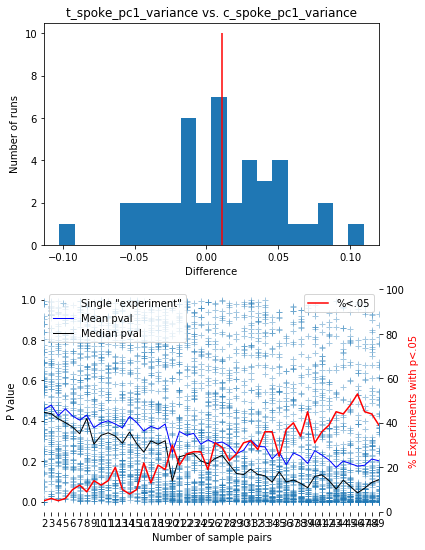

In [281]:
drawfigs(spms, measures=['t_spoke_pc1_variance', 'c_spoke_pc1_variance'])

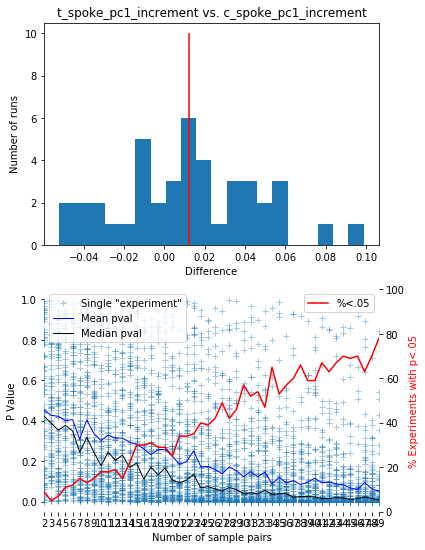

In [282]:
drawfigs(spms, measures=['t_spoke_pc1_increment', 'c_spoke_pc1_increment'])

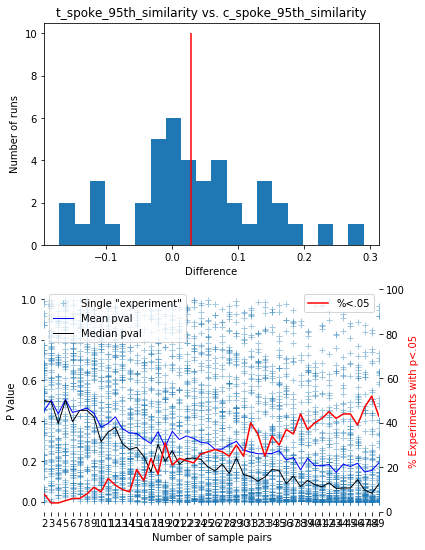

In [283]:
drawfigs(spms, measures=['t_spoke_95th_similarity', 'c_spoke_95th_similarity'])

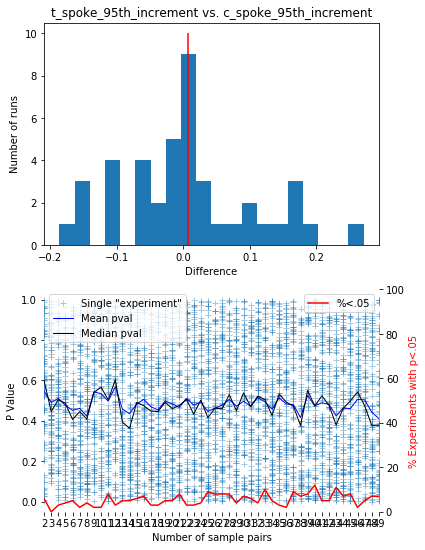

In [284]:
drawfigs(spms, measures=['t_spoke_95th_increment', 'c_spoke_95th_increment'])

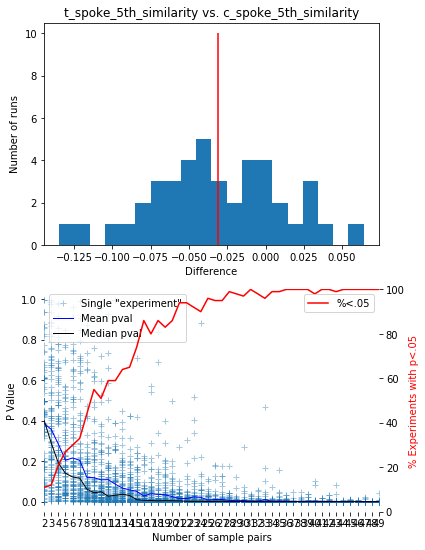

In [285]:
drawfigs(spms, measures=['t_spoke_5th_similarity', 'c_spoke_5th_similarity'])

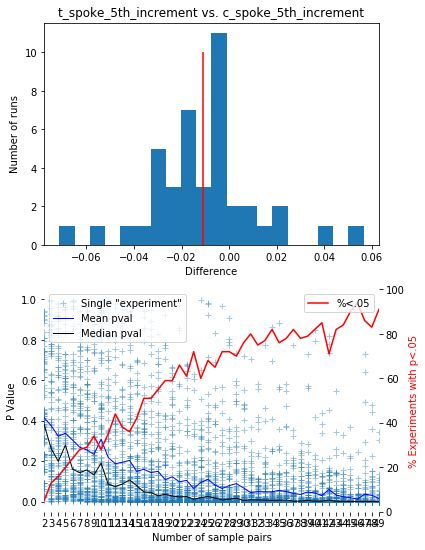

In [286]:
drawfigs(spms, measures=['t_spoke_5th_increment', 'c_spoke_5th_increment'])

The measures to report include:

- **Control Mean**: average of measures under treatment condition. Serves as a point of comparison for treatment effect magnitude.
- **Control Mean**: with bootstrap resampling, the mean control measure is within this interval in 95% of samples
- **Mean Difference**: average of the delta between pairs
- **Mean Difference ci**: with bootstrap resampling, the mean (paired) treatment effect is within this interval in 95% of samples
- **p value**: paired t-test p value for difference in means between treatment and control

In [253]:
def bootstrap_mean(l, q=(2.5, 97.5), n=1000):
    "Basic bootstrap confidence intervals (q) with n resamples"
    return np.percentile([np.mean(np.random.choice(l, size=len(l))) for _ in range(n)], q=q)


collector = []
for key in spms:
    if key.startswith('t'):
        control_key = 'c_'+key.lstrip('t_')
        collector.append({
            'Measure': key.lstrip('t_'), #.replace('_', ' ').title(),
            'Treatment Mean': spms[key].mean(),
            'Control Mean': spms[control_key].mean(),
            'Control Mean ci': bootstrap_mean(spms[control_key]),
            'Mean Difference': (spms[key] - spms[control_key]).mean(),
            'Mean Difference ci': bootstrap_mean((spms[key] - spms[control_key])),
            #'Percent Difference of Means': (spms[key] - spms[control_key]).mean() / spms[control_key].mean()*100,
            'p value': stats.ttest_rel(spms[key], spms[control_key])[1]
        })
r3 = pd.DataFrame(collector).set_index('Measure')
r3['p<.05'] = r3['p value'] < .05
r3

,Treatment Mean,Control Mean,Control Mean ci,Mean Difference,Mean Difference ci,p value,p<.05
Measure,,,,,,,
spoke_pc1_variance,0.247725,0.236543,"[0.22608468579331584, 0.24763943944277733]",0.011183,"[-0.0021392623280040565, 0.023934525597869127]",0.095772,False
spoke_5th_similarity,-0.235241,-0.204138,"[-0.21884540163733196, -0.19091894113401867]",-0.031103,"[-0.04307333122763203, -0.017691673453175055]",0.000032,True
spoke_95th_similarity,0.552052,0.523186,"[0.49979280735175, 0.5459140019330755]",0.028865,"[-0.002751815440244213, 0.060204169951495565]",0.081813,False
expected_pc1_variance,0.187485,0.188722,"[0.18432743933808451, 0.19302095384428594]",-0.001237,"[-0.007272012620587868, 0.005187149699370927]",0.687662,False
expected_95th_similarity,0.438686,0.416354,"[0.40606324958192835, 0.426978934749447]",0.022332,"[0.010671766616420317, 0.0339849659871887]",0.000483,True
expected_5th_similarity,-0.209344,-0.189195,"[-0.1978624655080193, -0.1807714058679597]",-0.020148,"[-0.028374365939299203, -0.011659217846542088]",0.000036,True
spoke_pc1_increment,0.060240,0.047821,"[0.03979514996284239, 0.057096682410505625]",0.012419,"[0.0028938723546415336, 0.023842843304705322]",0.024148,True
spoke_5th_increment,-0.025897,-0.014942,"[-0.02310950284148325, -0.008945066240879936]",-0.010955,"[-0.0173488784123602, -0.003789603056870583]",0.003512,True
spoke_95th_increment,0.113365,0.106832,"[0.08708754509534988, 0.12873201026677342]",0.006533,"[-0.023029062631497618, 0.03809532442275867]",0.676494,False


In [27]:
collector = []
for key in caveman_spms:
    if key.startswith('t'):
        control_key = 'c_'+key.lstrip('t_')
        collector.append({
            'Measure': key.lstrip('t_'), #.replace('_', ' ').title(),
            'Treatment Mean': caveman_spms[key].mean(),
            'Control Mean': caveman_spms[control_key].mean(),
            'Control Mean ci': bootstrap_mean(caveman_spms[control_key]),
            'Mean Difference': (caveman_spms[key] - caveman_spms[control_key]).mean(),
            'Mean Difference ci': bootstrap_mean((caveman_spms[key] - caveman_spms[control_key])),
            #'Percent Difference of Means': (caveman_spms[key] - caveman_spms[control_key]).mean() / caveman_spms[control_key].mean()*100,
            'p value': stats.ttest_rel(caveman_spms[key], caveman_spms[control_key])[1]
        })
caveman_r3 = pd.DataFrame(collector).set_index('Measure')
caveman_r3

,Treatment Mean,Control Mean,Control Mean ci,Mean Difference,Mean Difference ci,p value
Measure,,,,,,
survey_pc1_variance,0.399013,0.397280,"[0.33225126310879805, 0.4623088412466364]",0.001733,"[-0.12278632640912357, 0.12625193520255687]",0.982660
survey_5th_similarity,-0.537465,-0.634891,"[-0.7135555461423442, -0.523496141084681]",0.097426,"[-0.022285978796344585, 0.197152543025862]",0.247113
survey_95th_similarity,0.795191,0.731099,"[0.7199826828635578, 0.7422153225697807]",0.064092,"[-0.00577326814250903, 0.11641338037620061]",0.165825
spoke_pc1_variance,0.424723,0.432124,"[0.39259711031751277, 0.489025479568985]",-0.007401,"[-0.09283729510858725, 0.08588401464911731]",0.892552
spoke_5th_similarity,-0.353281,-0.386968,"[-0.4699103148551492, -0.3040263214291721]",0.033688,"[-0.06824702763496945, 0.14556578966974387]",0.614672
spoke_95th_similarity,0.856145,0.825894,"[0.7960274442457063, 0.8762904185252364]",0.030251,"[-0.09986059061087982, 0.14284766510228636]",0.694897
confidence,56.487500,52.500000,"[47.775, 56.45]",3.987500,"[-3.8749999999999964, 13.937500000000004]",0.492393
consensus,57.787500,53.625000,"[50.2375, 55.787499999999994]",4.162500,"[-2.024999999999997, 13.912499999999998]",0.439501


# Plots

([<matplotlib.axis.YTick at 0x1a2c6e3e10>,
 <a list of 3 Text yticklabel objects>)

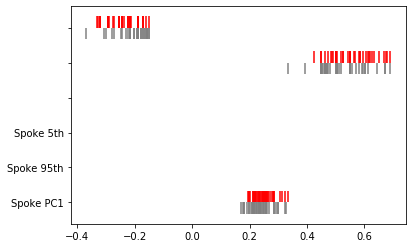

In [9]:
plt.vlines(spms['c_spoke_pc1_variance'], ymin=0, ymax=1, color='grey')
plt.vlines(spms['t_spoke_pc1_variance'], ymin=1, ymax=2, color='r')

plt.vlines(spms['c_spoke_95th_similarity'], ymin=12, ymax=13, color='grey')
plt.vlines(spms['t_spoke_95th_similarity'], ymin=13, ymax=14, color='r')

plt.vlines(spms['c_spoke_5th_similarity'], ymin=15, ymax=16, color='grey')
plt.vlines(spms['t_spoke_5th_similarity'], ymin=16, ymax=17, color='r')



plt.yticks([1, 4, 7, 10, 13, 16], ['Spoke PC1', 'Spoke 95th', 'Spoke 5th'])

In [10]:
plt.vlines(spms['c_survey_pc1_variance'], ymin=0, ymax=1, color='grey')
plt.vlines(spms['t_survey_pc1_variance'], ymin=1, ymax=2, color='r')

plt.vlines(spms['c_survey_95th_similarity'], ymin=3, ymax=4, color='grey')
plt.vlines(spms['t_survey_95th_similarity'], ymin=4, ymax=5, color='r')

plt.vlines(spms['c_survey_5th_similarity'], ymin=6, ymax=7, color='grey')
plt.vlines(spms['t_survey_5th_similarity'], ymin=7, ymax=8, color='r')

# plt.vlines(spms['c_spoke_pc1_growth'], ymin=9, ymax=10, color='grey')
# plt.vlines(spms['t_spoke_pc1_growth'], ymin=10, ymax=11, color='r')

plt.vlines(spms['c_spoke_95th_similarity'], ymin=12, ymax=13, color='grey')
plt.vlines(spms['t_spoke_95th_similarity'], ymin=13, ymax=14, color='r')

plt.vlines(spms['c_spoke_5th_similarity'], ymin=15, ymax=16, color='grey')
plt.vlines(spms['t_spoke_5th_similarity'], ymin=16, ymax=17, color='r')



plt.yticks([1, 4, 7, 10, 13, 16], ['Survey PC1', 'Survey 95th', 'Survey 5th', 'Spoke PC1 Growth', 'Spoke 95th', 'Spoke 5th'])

KeyError: 'c_survey_pc1_variance'

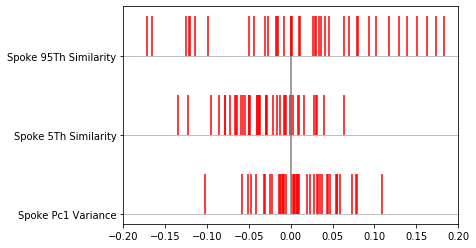

In [11]:
labels = []
ys = []
for i, key in enumerate(spms):
    if key.startswith('t'):
        control_key = 'c_'+key.lstrip('t_')
        y = 2*i
        ys.append(y)
        plt.vlines(spms[key] - spms[control_key], ymin=y, ymax=y+1, color='r')
        labels.append(key.lstrip('t_').replace('_', ' ').title())
plt.yticks(ys, labels)
plt.xlim(-.2,.2)
plt.vlines(0, 0, max(ys), color='grey')
#plt.axis('off')
plt.grid(axis='y')

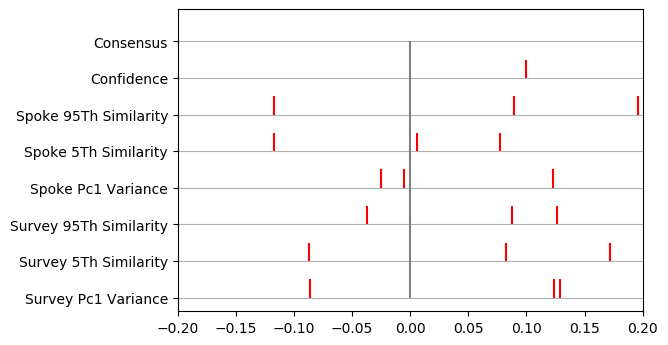

In [94]:
labels = []
ys = []
for i, key in enumerate(caveman_spms):
    if key.startswith('t'):
        control_key = 'c_'+key.lstrip('t_')
        y = 2*i
        ys.append(y)
        plt.vlines(caveman_spms[key] - caveman_spms[control_key], ymin=y, ymax=y+1, color='r')
        labels.append(key.lstrip('t_').replace('_', ' ').title())
plt.yticks(ys, labels)
plt.xlim(-.2,.2)
plt.vlines(0, 0, max(ys), color='grey')
#plt.axis('off')
plt.grid(axis='y')

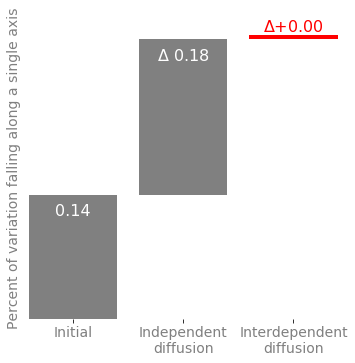

In [36]:
plt.figure(figsize=(5,5))

start = r3.loc['spoke_pc1_initial_variance']['Treatment Mean']
control = r3.loc['spoke_pc1_variance']['Control Mean']
treatment = r3.loc['spoke_pc1_variance']['Treatment Mean']

plt.bar(x=[0,1,2], 
        height=[start,
                control-start, 
                treatment-control],
        bottom=[0, 
                start,
                control], 
        color=['grey', 'grey', 'r'])


plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.box(on=False)

plt.xlim(-.5, 2.5)
plt.xticks([0,1,2], ['Initial', 'Independent\ndiffusion', 'Interdependent\ndiffusion'], 
           ha='center', fontsize=14, color='grey');
plt.yticks([])
plt.text(0, start-.01, '%.02f'%start, ha='center', va='top', color='white', fontsize=16)
plt.text(1, control-.01, '$\Delta$ %.02f'%(control-start), ha='center', va='top', color='white', fontsize=16)
plt.text(2, treatment, '$\Delta$+%.02f'%(treatment-control), ha='center', va='bottom', color='r', fontsize=16)

          
plt.figtext(x=0, y=1, rotation=90, va='top', fontsize=14, color='grey',
            s='Percent of variation falling along a single axis')
plt.tight_layout()

In [ ]:
plt.figure(figsize=(5,5))

#start = r3.loc['survey_pc1_initial_variance']['Treatment Mean']
control = r3.loc['survey_pc1_variance']['Control Mean']
treatment = r3.loc['survey_pc1_variance']['Treatment Mean']

plt.bar(x=[0,1,2], 
        height=[start,
                control-start, 
                treatment-control],
        bottom=[0, 
                start,
                control], 
        color=['grey', 'grey', 'r'])


plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.box(on=False)

plt.xlim(-.5, 2.5)
plt.xticks([0,1,2], ['Initial', 'Independent\ndiffusion', 'Interdependent\ndiffusion'], 
           ha='center', fontsize=14, color='grey');
plt.yticks([])
plt.text(0, start-.01, '%.02f'%start, ha='center', va='top', color='white', fontsize=16)
plt.text(1, control-.01, '$\Delta$ %.02f'%(control-start), ha='center', va='top', color='white', fontsize=16)
plt.text(2, treatment, '$\Delta$+%.02f'%(treatment-control), ha='center', va='bottom', color='r', fontsize=16)

          
plt.figtext(x=0, y=1, rotation=90, va='top', fontsize=14, color='grey',
            s='Percent of variation falling along a single axis')
plt.tight_layout()

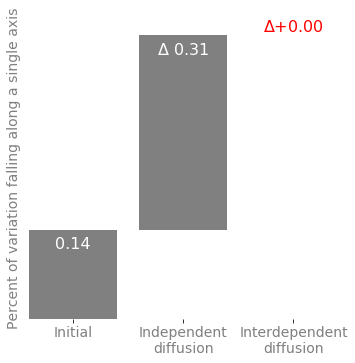

In [37]:
plt.figure(figsize=(5,5))

start = caveman_r3.loc['spoke_pc1_initial_variance']['Treatment Mean']
control = caveman_r3.loc['spoke_pc1_variance']['Control Mean']
treatment = caveman_r3.loc['spoke_pc1_variance']['Treatment Mean']

plt.bar(x=[0,1,2], 
        height=[start,
                control-start, 
                treatment-control],
        bottom=[0, 
                start,
                control], 
        color=['grey', 'grey', 'r'])


plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.box(on=False)

plt.xlim(-.5, 2.5)
plt.xticks([0,1,2], ['Initial', 'Independent\ndiffusion', 'Interdependent\ndiffusion'], 
           ha='center', fontsize=14, color='grey');
plt.yticks([])
plt.text(0, start-.01, '%.02f'%start, ha='center', va='top', color='white', fontsize=16)
plt.text(1, control-.01, '$\Delta$ %.02f'%(control-start), ha='center', va='top', color='white', fontsize=16)
plt.text(2, treatment, '$\Delta$+%.02f'%(treatment-control), ha='center', va='bottom', color='r', fontsize=16)

          
plt.figtext(x=0, y=1, rotation=90, va='top', fontsize=14, color='grey',
            s='Percent of variation falling along a single axis')
plt.tight_layout()

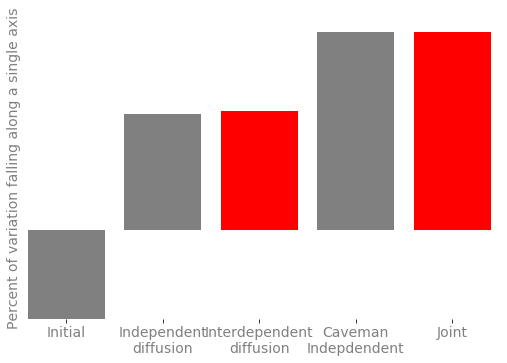

In [38]:
plt.figure(figsize=(7,5))

start = caveman_r3.loc['spoke_pc1_initial_variance']['Treatment Mean']
caveman_control = caveman_r3.loc['spoke_pc1_variance']['Control Mean']
caveman_treatment = caveman_r3.loc['spoke_pc1_variance']['Treatment Mean']
control = r3.loc['spoke_pc1_variance']['Control Mean']
treatment = r3.loc['spoke_pc1_variance']['Treatment Mean']


plt.bar(x=[0,1,2,3,4], 
        height=[start,
                control-start, 
                treatment-start,
                caveman_control-start,
                caveman_treatment-start],
        bottom=[0, 
                start,
                start,
                start,
                start], 
        color=['grey', 'grey', 'r', 'grey', 'r'])


plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.box(on=False)

plt.xlim(-.5, 4.5)
plt.xticks([0,1,2,3,4], ['Initial', 'Independent\ndiffusion', 'Interdependent\ndiffusion',
                         'Caveman\nIndepdendent', 'Joint'], 
           ha='center', fontsize=14, color='grey');
plt.yticks([])
#plt.text(0, start-.01, '%.02f'%start, ha='center', va='top', color='white', fontsize=16)
#plt.text(1, control-.01, '$\Delta$ %.02f'%(control-start), ha='center', va='top', color='white', fontsize=16)
#plt.text(2, treatment, '$\Delta$+%.02f'%(treatment-control), ha='center', va='bottom', color='r', fontsize=16)

          
plt.figtext(x=0, y=1, rotation=90, va='top', fontsize=14, color='grey',
            s='Percent of variation falling along a single axis')
plt.tight_layout()

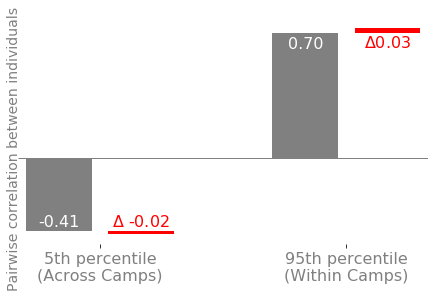

In [39]:

control_across = r3.loc['survey_5th_similarity']['Control Mean']
treatment_across = r3.loc['survey_5th_similarity']['Treatment Mean']
control_within = r3.loc['survey_95th_similarity']['Control Mean']
treatment_within = r3.loc['survey_95th_similarity']['Treatment Mean']

plt.bar(x=[0,1, 3,4], 
        height=[control_across, treatment_across-control_across, 
                control_within, treatment_within-control_within],
        bottom=[0, control_across, 0, control_within], 
        color=['grey', 'r', 'grey', 'r'])

plt.box(on=False)
plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.xlim(-.5, 4.5)
plt.xticks([0.5,3.5], ['5th percentile\n(Across Camps)', '95th percentile\n(Within Camps)'], ha='center', fontsize=16, color='grey');
plt.yticks([])

plt.text(0, control_across+.01, '%.02f'%control_across, 
         ha='center', va='bottom', color='white', fontsize=16)
plt.text(1, control_across+.01, '$\Delta$ %.02f'%(treatment_across-control_across), 
         ha='center', va='bottom', color='r', fontsize=16)
plt.text(3, control_within-.02, '%.02f'%control_within, 
         ha='center', va='top', color='white', fontsize=16)
plt.text(4, control_within-.01, '$\Delta$%.02f'%(treatment_within-control_within), 
         ha='center', va='top', color='r', fontsize=16)

plt.figtext(x=0, y=1, s='Pairwise correlation between individuals', 
            rotation=90, va='top', color='grey', fontsize=14)
plt.tight_layout()


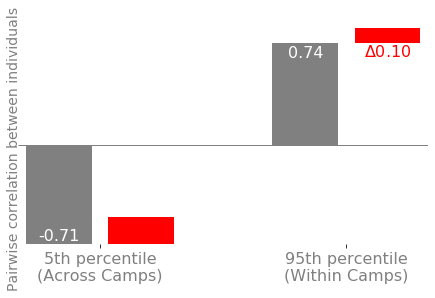

In [40]:
control_across = caveman_r3.loc['survey_5th_similarity']['Control Mean']
treatment_across = caveman_r3.loc['survey_5th_similarity']['Treatment Mean']
control_within = caveman_r3.loc['survey_95th_similarity']['Control Mean']
treatment_within = caveman_r3.loc['survey_95th_similarity']['Treatment Mean']

plt.bar(x=[0,1, 3,4], 
        height=[control_across, treatment_across-control_across, 
                control_within, treatment_within-control_within],
        bottom=[0, control_across, 0, control_within], 
        color=['grey', 'r', 'grey', 'r'])

plt.box(on=False)
plt.hlines(0, -.5, 4.5, linewidth=1, color='grey')
plt.xlim(-.5, 4.5)
plt.xticks([0.5,3.5], ['5th percentile\n(Across Camps)', '95th percentile\n(Within Camps)'], ha='center', fontsize=16, color='grey');
plt.yticks([])

plt.text(0, control_across+.01, '%.02f'%control_across, 
         ha='center', va='bottom', color='white', fontsize=16)
plt.text(1, control_across+.01, '$\Delta$ %.02f'%(treatment_across-control_across), 
         ha='center', va='bottom', color='r', fontsize=16)
plt.text(3, control_within-.02, '%.02f'%control_within, 
         ha='center', va='top', color='white', fontsize=16)
plt.text(4, control_within-.01, '$\Delta$%.02f'%(treatment_within-control_within), 
         ha='center', va='top', color='r', fontsize=16)

plt.figtext(x=0, y=1, s='Pairwise correlation between individuals', 
            rotation=90, va='top', color='grey', fontsize=14)
plt.tight_layout()

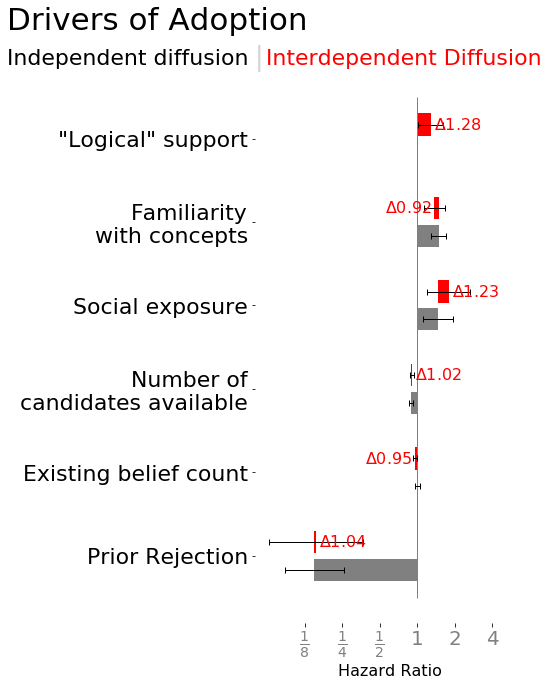

In [53]:
plt.figure(figsize=(8,10))
plt.rcParams["font.family"] = "san-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"


ctrl = ['in_deads', 'n_existing_beliefs', 'n_fresh_candidates', 'n_exposures', 'references']
trmt = ['treatment_in_deads', 'treatment_n_existing_beliefs', 'treatment_n_fresh_candidates', 
        'treatment_n_exposures', 'treatment_references', 'treatment_pl2']


ctrl_ys = np.arange(0, len(trmt)*3,3)
trmt_ys = ctrl_ys + 1

ctrl_width = list(r1['coef'].loc[ctrl])+[0]
trmt_diff =list(r1['coef'].loc[trmt])

ctrl_95 = log(r1[['lower .95', 'upper .95']].T[ctrl])
trmt_95 = log(r1[['lower .95', 'upper .95']].T[trmt])+ctrl_width

plt.barh(y=ctrl_ys, 
         width=ctrl_width,
         left=0, 
         color='grey')

plt.plot(ctrl_95, 
         [ctrl_ys[:-1], ctrl_ys[:-1]], 
         'k-|', linewidth=1, alpha=1)

plt.barh(y=trmt_ys, 
         width=trmt_diff,
         left=ctrl_width, 
         color='red')

plt.plot(trmt_95, 
         [trmt_ys, trmt_ys], 
         'k-|', linewidth=1, alpha=1)


plt.xlim(-3, 2)

labels = ['Prior Rejection', 'Existing belief count', 'Number of\ncandidates available',  
          'Social exposure', 'Familiarity\nwith concepts', '"Logical" support']
plt.yticks(np.arange(0.5, len(trmt)*3, 3), labels, fontsize=22)
plt.xticks(np.log([.125, .25,.5,1,2,4]), [r'$\frac{1}{8}$', r'$\frac{1}{4}$',r'$\frac{1}{2}$',1,2,4], 
           fontsize=20, color='grey')
plt.xlabel('Hazard Ratio', fontsize=16)

plt.vlines(0, -1, len(trmt)*3-1, linewidth=1, color='grey')
plt.box(False)


for td, cw, y in zip(trmt_diff, ctrl_width, trmt_ys):
    xp = td + cw + .05 * np.sign(td)
    plt.text(#xp, y, '$\Delta$%s%.02f'%('+' if td>=0 else '', exp(td)-1), 
             xp, y, '$\Delta$%.02f'%(exp(td)), 
             ha='left' if td>0 else 'right', 
             va='center', color='r', fontsize=16, alpha=1)



plt.suptitle('Drivers of Adoption', x=0, ha='left', fontsize=31)
plt.figtext(x=0, y=.9, s='Independent diffusion',  ha='left', fontsize=22)
plt.figtext(x=.43, y=.9, s='|',  ha='left', fontsize=26, color='lightgrey')
plt.figtext(x=.45, y=.9, s='Interdependent Diffusion',  ha='left', fontsize=22, color='r')


plt.subplots_adjust(top=.89, left=.43)
# plt.savefig('/Users/jameshoughton/Google Drive/MIT PhD/Factionalism_Research/Thesis/drivers_of_adoption_logic_0.png', dpi=150)


/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.


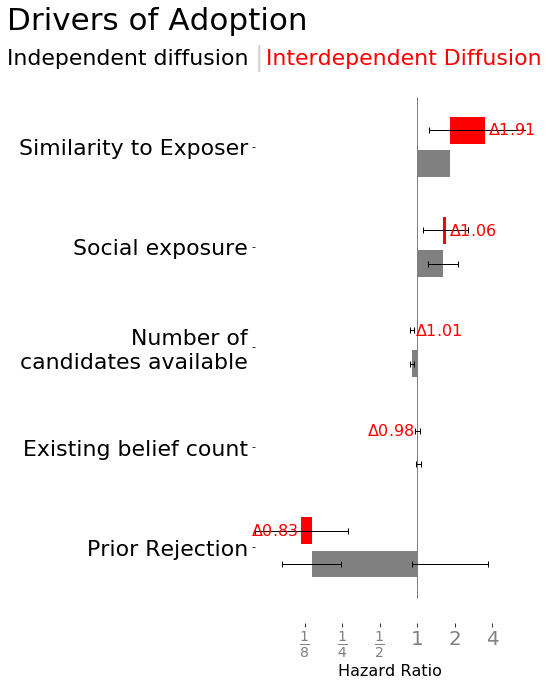

In [54]:
plt.figure(figsize=(8,10))
plt.rcParams["font.family"] = "san-serif"
plt.rcParams["font.sans-serif"] = "Helvetica"


ctrl = ['in_deads', 'n_existing_beliefs', 'n_fresh_candidates', 'n_exposures', 'max_similarity_to_exposer']
trmt = ['treatment_in_deads', 'treatment_n_existing_beliefs', 'treatment_n_fresh_candidates', 
        'treatment_n_exposures', 'treatment_max_similarity_to_exposer']


ctrl_ys = np.arange(0, len(trmt)*3,3)
trmt_ys = ctrl_ys + 1

ctrl_width = list(r2['coef'].loc[ctrl])
trmt_diff =list(r2['coef'].loc[trmt])

ctrl_95 = log(r2[['lower .95', 'upper .95']].T[ctrl])
trmt_95 = log(r2[['lower .95', 'upper .95']].T[trmt])+ctrl_width

plt.barh(y=ctrl_ys, 
         width=ctrl_width,
         left=0, 
         color='grey')

plt.plot(ctrl_95, 
         [ctrl_ys[:-1], ctrl_ys[:-1]], 
         'k-|', linewidth=1, alpha=1)

plt.barh(y=trmt_ys, 
         width=trmt_diff,
         left=ctrl_width, 
         color='red')

plt.plot(trmt_95, 
         [trmt_ys, trmt_ys], 
         'k-|', linewidth=1, alpha=1)


plt.xlim(-3, 2)

labels = ['Prior Rejection', 'Existing belief count', 'Number of\ncandidates available',  
          'Social exposure', 'Similarity to Exposer']
plt.yticks(np.arange(0.5, len(trmt)*3, 3), labels, fontsize=22)
plt.xticks(np.log([.125, .25,.5,1,2,4]), [r'$\frac{1}{8}$', r'$\frac{1}{4}$',r'$\frac{1}{2}$',1,2,4], 
           fontsize=20, color='grey')
plt.xlabel('Hazard Ratio', fontsize=16)

plt.vlines(0, -1, len(trmt)*3-1, linewidth=1, color='grey')
plt.box(False)


for td, cw, y in zip(trmt_diff, ctrl_width, trmt_ys):
    xp = td + cw + .05 * np.sign(td)
    plt.text(#xp, y, '$\Delta$%s%.02f'%('+' if td>=0 else '', exp(td)-1), 
             xp, y, '$\Delta$%.02f'%(exp(td)), 
             ha='left' if td>0 else 'right', 
             va='center', color='r', fontsize=16, alpha=1)



plt.suptitle('Drivers of Adoption', x=0, ha='left', fontsize=31)
plt.figtext(x=0, y=.9, s='Independent diffusion',  ha='left', fontsize=22)
plt.figtext(x=.43, y=.9, s='|',  ha='left', fontsize=26, color='lightgrey')
plt.figtext(x=.45, y=.9, s='Interdependent Diffusion',  ha='left', fontsize=22, color='r')


plt.subplots_adjust(top=.89, left=.43)
# plt.savefig('/Users/jameshoughton/Google Drive/MIT PhD/Factionalism_Research/Thesis/drivers_of_adoption_logic_0.png', dpi=150)


# open responses

In [13]:
def process_open_responses(process_games):
    
    count = 0
    fair = []
    length = []
    feedback = []
    t_idle = []
    c_idle = []
    
    for game in process_games:
        
        for player_id, player in game['players'].items():
            count +=1
        
        for player_id, player in game['players'].items():
            if 'data.survey' in player.keys():
                if 'fair' in player['data.survey'].keys():
                    s = player['data.survey']['fair']
                    fair.append(s.lower().translate(str.maketrans('', '', string.punctuation)))

        for player_id, player in game['players'].items():
            if 'data.survey' in player.keys():
                if 'time' in player['data.survey'].keys():
                    s = player['data.survey']['time']
                    length.append(s.lower().translate(str.maketrans('', '', string.punctuation)))

        for player_id, player in game['players'].items():
            if 'data.survey' in player.keys():
                if 'feedback' in player['data.survey'].keys():
                    s = player['data.survey']['feedback']
                    feedback.append(s.lower().translate(str.maketrans('', '', string.punctuation)))
                    
        for player_id, player in game['players'].items():
            if 'data.active' in player.keys():
                if player['data.position'].startswith('t'):
                    t_idle.append(player['data.active'])
                elif player['data.position'].startswith('c'):
                    c_idle.append(player['data.active'])


                    
    return (pd.DataFrame(pd.Series(fair).value_counts()), 
            pd.DataFrame(pd.Series(length).value_counts()), 
            pd.DataFrame(pd.Series(feedback).value_counts()),
            pd.DataFrame(pd.Series(t_idle).value_counts()),
            pd.DataFrame(pd.Series(c_idle).value_counts()),
            count
           )

fair, length, feedback, t_idle, c_idle, count = process_open_responses(process_games)

In [10]:
pd.options.display.max_rows = 999
fair

,0
yes,158
yes,4
yes very fair,4
no,3
yes very,3
yeah,3
very fair,2
yes thank you,2
more than fair,2
definitely fair,1


In [49]:
length

,0
yes,133
yes i did,4
yes,3
yeah,2
yes more than enough,2
no,2
yes too much time,1
i think so,1
enough time,1
more than enough time,1


In [12]:
pd.options.display.max_rows = 999
feedback

,0
,48
none,35
na,4
no problems,4
no issues,4
i did not encounter any problems,2
thank you,2
fun survey,2
none thanks,2
no problems encountered,2


In [51]:
t_idle

,0
idle once,20


In [52]:
c_idle

,0
idle once,24
